# BirdCLEF 2024 Initial Notebook
* Classify audio recordings of birds
* First look at frequency based features
    * FFT analysis
    * Librosa stuff, harmonic, percussive, zero-crossings, etc.
    * Run first model on these features, using gradient boosted trees (Catboost, XGBoost, LightGBM)
* Then save spectrograms as image files and set up to treat it as an image classification problem

# Installs
* Internet is off in this comp, so install as an attached dataset

In [1]:
kaggle = False

In [2]:
if kaggle:
    !pip install -q /kaggle/input/scienceplots-2-1-0/SciencePlots-2.1.0-py3-none-any.whl

# Imports

In [5]:
import os
import numpy as np 
import pandas as pd 
pd.set_option('display.max_columns', 50)

import matplotlib.pyplot as plt 
import plotly.express as px
import seaborn as sns
sns.set_style('whitegrid')

import librosa
import librosa.display
import IPython.display as ipd

from tqdm.auto import tqdm


import warnings
warnings.filterwarnings("ignore")

import scienceplots
plt.style.use(['science','no-latex'])

# Load Data

In [17]:
if kaggle: 
    root_dir = '/kaggle/input/birdclef-2024'
else:
    root_dir = '.'
    
train_audio_dir = root_dir + '/train_audio/'
train = pd.read_csv(root_dir + '/train_metadata.csv') 
tax = pd.read_csv(root_dir + '/eBird_Taxonomy_v2021.csv') 
ss = pd.read_csv(root_dir + '/sample_submission.csv')

# Top Level View

In [8]:
# print all sets - assuming train,test, ss
print(f'Training Data Shape: {train.shape}') 
display(train.head()) 
print(f'Tax Data Shape: {tax.shape}') 
display(tax.head()) 
print(f'Sample Submission Shape: {ss.shape}') 
display(ss.head())

Training Data Shape: (24459, 12)


,primary_label,secondary_labels,type,latitude,longitude,scientific_name,common_name,author,license,rating,url,filename
0,asbfly,[],['call'],39.2297,118.1987,Muscicapa dauurica,Asian Brown Flycatcher,Matt Slaymaker,Creative Commons Attribution-NonCommercial-Sha...,5.0,https://www.xeno-canto.org/134896,asbfly/XC134896.ogg
1,asbfly,[],['song'],51.4030,104.6401,Muscicapa dauurica,Asian Brown Flycatcher,Magnus Hellström,Creative Commons Attribution-NonCommercial-Sha...,2.5,https://www.xeno-canto.org/164848,asbfly/XC164848.ogg
2,asbfly,[],['song'],36.3319,127.3555,Muscicapa dauurica,Asian Brown Flycatcher,Stuart Fisher,Creative Commons Attribution-NonCommercial-Sha...,2.5,https://www.xeno-canto.org/175797,asbfly/XC175797.ogg
3,asbfly,[],['call'],21.1697,70.6005,Muscicapa dauurica,Asian Brown Flycatcher,vir joshi,Creative Commons Attribution-NonCommercial-Sha...,4.0,https://www.xeno-canto.org/207738,asbfly/XC207738.ogg
4,asbfly,[],['call'],15.5442,73.7733,Muscicapa dauurica,Asian Brown Flycatcher,Albert Lastukhin & Sergei Karpeev,Creative Commons Attribution-NonCommercial-Sha...,4.0,https://www.xeno-canto.org/209218,asbfly/XC209218.ogg


Tax Data Shape: (16753, 9)


,TAXON_ORDER,CATEGORY,SPECIES_CODE,PRIMARY_COM_NAME,SCI_NAME,ORDER1,FAMILY,SPECIES_GROUP,REPORT_AS
0,1,species,ostric2,Common Ostrich,Struthio camelus,Struthioniformes,Struthionidae (Ostriches),Ostriches,NaN
1,6,species,ostric3,Somali Ostrich,Struthio molybdophanes,Struthioniformes,Struthionidae (Ostriches),NaN,NaN
2,7,slash,y00934,Common/Somali Ostrich,Struthio camelus/molybdophanes,Struthioniformes,Struthionidae (Ostriches),NaN,NaN
3,8,species,grerhe1,Greater Rhea,Rhea americana,Rheiformes,Rheidae (Rheas),Rheas,NaN
4,14,species,lesrhe2,Lesser Rhea,Rhea pennata,Rheiformes,Rheidae (Rheas),NaN,NaN


Sample Submission Shape: (3, 183)


,row_id,asbfly,ashdro1,ashpri1,ashwoo2,asikoe2,asiope1,aspfly1,aspswi1,barfly1,barswa,bcnher,bkcbul1,bkrfla1,bkskit1,bkwsti,bladro1,blaeag1,blakit1,blhori1,blnmon1,blrwar1,bncwoo3,brakit1,brasta1,...,sqtbul1,stbkin1,sttwoo1,thbwar1,tibfly3,tilwar1,vefnut1,vehpar1,wbbfly1,wemhar1,whbbul2,whbsho3,whbtre1,whbwag1,whbwat1,whbwoo2,whcbar1,whiter2,whrmun,whtkin2,woosan,wynlau1,yebbab1,yebbul3,zitcis1
0,soundscape_1446779_5,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,...,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495
1,soundscape_1446779_10,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,...,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495
2,soundscape_1446779_15,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,...,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495


In [9]:
# looks like there are 182 bird types
print(f'Length of unique bird types: {len(train.common_name.unique())}\n')
print(f'Bird types: {list(train.common_name.unique())}')

Length of unique bird types: 182

Bird types: ['Asian Brown Flycatcher', 'Ashy Drongo', 'Ashy Prinia', 'Ashy Woodswallow', 'Asian Koel', 'Asian Openbill', 'Indian Paradise-Flycatcher', 'Asian Palm-Swift', 'Black-and-orange Flycatcher', 'Barn Swallow', 'Black-crowned Night-Heron', 'Flame-throated Bulbul', 'Black-rumped Flameback', 'Black-winged Kite', 'Black-winged Stilt', 'Black Drongo', 'Black Eagle', 'Black Kite', 'Black-hooded Oriole', 'Black-naped Monarch', "Blyth's Reed Warbler", 'Brown-capped Pygmy Woodpecker', 'Brahminy Kite', 'Brahminy Starling', 'Brown-cheeked Fulvetta', 'Brown Fish-Owl', 'Brown Boobook', 'Brown Shrike', 'Bronzed Drongo', 'Bronze-winged Jacana', 'Brown Wood-Owl', 'Blue-tailed Bee-eater', 'Bar-winged Flycatcher-shrike', 'Cattle Egret', 'Chestnut-headed Bee-eater', 'Common Hawk-Cuckoo', 'Common Flameback', 'Common Greenshank', 'Common Iora', 'Common Kingfisher', 'Eurasian Moorhen', 'Common Myna', 'Indian Peafowl', 'Common Rosefinch', 'Common Sandpiper', 'Common 

# Missing Data

In [12]:
def df_info(df): 
  summary = pd.DataFrame(df.dtypes, columns=['dtypes']) 
  summary['missing#'] = df.isna().sum() 
  summary['missing%'] = (df.isna().sum())/len(df) 
  summary['uniques'] = df.nunique().values 
  summary['count'] = df.count().values 
  return summary

df_info(train)#.style.background_gradient(cmap='Blues')  # gradient not working locally

,dtypes,missing#,missing%,uniques,count
primary_label,object,0,0.000000,182,24459
secondary_labels,object,0,0.000000,491,24459
type,object,0,0.000000,918,24459
latitude,float64,378,0.015454,9098,24081
longitude,float64,378,0.015454,9182,24081
scientific_name,object,0,0.000000,182,24459
common_name,object,0,0.000000,182,24459
author,object,0,0.000000,1942,24459
license,object,0,0.000000,4,24459
rating,float64,0,0.000000,11,24459


* All data is there except for some (1.5%) lat/lon coordinates

## Secondary Labels

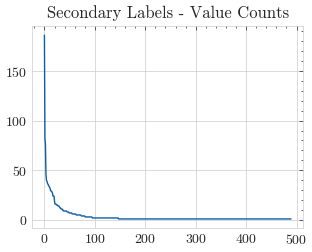

In [13]:
# look at secondary labels
secondary = train.secondary_labels.value_counts()
vals = secondary.values
plt.plot(vals[1:])
plt.title('Secondary Labels - Value Counts')
plt.show()

In [14]:
np.sum(vals[vals==1])  # 343 values with 1

343

### Takeaways
* there are 182 birds to classify
* From sumbission file, looks like it is broken into 5 sec chunks and need to predict a probability for each bird in each time interval. 
* of 24459 records, 22567 have no secondary labels, means that only 1892 have other birds, or around 8%
    * Maybe start with records that have no secondary labels.

## Check for any missing .ogg files

In [18]:
files = train.filename.values

In [19]:
exist_count = 0
for file in tqdm(files):
        if os.path.exists(train_audio_dir + file):
            exist_count +=1
        else:
            print(f'file: {file} not found.')
print(f'exist count = {exist_count}')
print(f'All files accounted for: {exist_count == len(train)}')

  0%|          | 0/24459 [00:00<?, ?it/s]

exist count = 24459
All files accounted for: True


## Look at the distribution of bird types

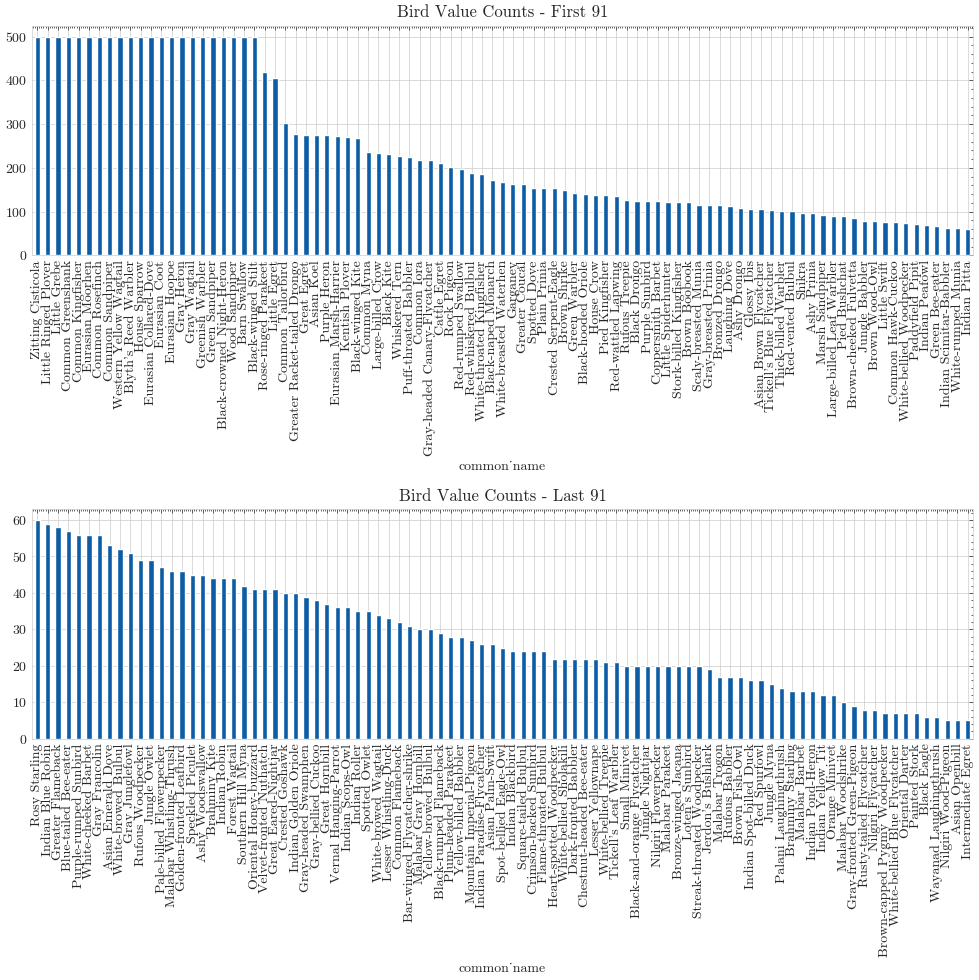

In [44]:
# break the value counts into two halves and plot the first 91 in one plot then the rest in another
plt.figure(figsize=(10,10),tight_layout=True)
plt.subplot(2,1,1)
train.common_name.value_counts().iloc[:91].plot(kind='bar')
plt.title('Bird Value Counts - First 91')
plt.subplot(2,1,2)
train.common_name.value_counts().iloc[91:].plot(kind='bar')
plt.title('Bird Value Counts - Last 91')
plt.show()


### Takeaways 
* Pretty significant imbalance, some have 500 samples, others have only 5  
* Will probably need to address this, maybe with a weighted loss function or oversampling
* Also, stratified CV.

## Look at a sample audio file in Librosa

In [20]:
# look at waveform properties
file_idx = 0
fname = train_audio_dir + files[file_idx]

wf, sr = librosa.load(fname,sr=None)
print(f'Waveform shape: {wf.shape}\nSample Rate: {sr}')

Waveform shape: (875207,)
Sample Rate: 32000


### Need to specify sr=none for librosa, else it will default to 22050Hz

Why for default, I get: Waveform shape: (603073,), Sample Rate: 22050 <br>
But for sr=None, I get:  Waveform shape: (875207,), Sample Rate: 32000 <br>
<p>
I would assume shapes should be the same...


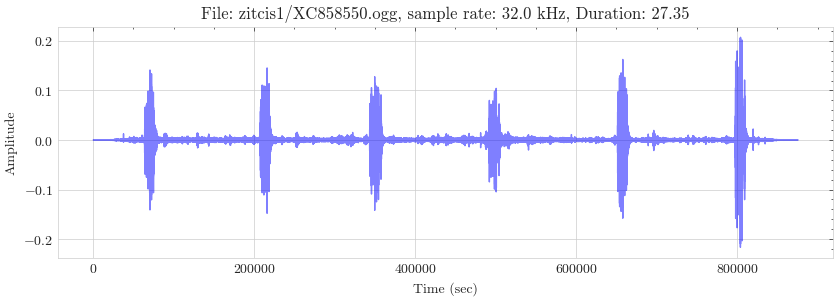

In [22]:
# # zoom in a level or two
# fig, ax = plt.subplots(nrows=4, sharex=False,figsize=(15,16))
# librosa.display.waveshow(wf, sr=sr, ax=ax[0],alpha=0.5)
# ax[0].set(title='Raw Audio Sample All')
# ax[0].label_outer()
# librosa.display.waveshow(wf[50000:150000], sr=sr, ax=ax[1],alpha=0.5)
# ax[1].set(title='Raw Audio Sample 100000 Points')
# ax[1].label_outer()
# librosa.display.waveshow(wf[50000:60000], sr=sr, ax=ax[2],alpha=0.5)
# ax[2].set(title='Raw Audio Sample 10000 Points')
# ax[2].label_outer()
# librosa.display.waveshow(wf[50000:50500], sr=sr, ax=ax[3],alpha=0.5)
# ax[3].set(title='Raw Audio Sample 500 Points')
# ax[3].label_outer()

l_end = len(wf)/sr
plt.figure(figsize=(10,3))
#librosa.display.waveshow(wf, sr=sr,alpha=0.5)  # librosa display not working locally
plt.plot(wf, color='b', alpha=0.5)
plt.title(f'File: {file}, sample rate: {sr/1000} kHz, Duration: {l_end:.2f}')
plt.xlabel('Time (sec)')
plt.ylabel('Amplitude')
plt.show()
plt.show()


## More Librosa Feature Extraction

* Beat tempo
* Harmonic and Percussive Components
* RMS
* Zero crossings



### Tempo

In [23]:
# tempo
tempo, _ = librosa.beat.beat_track(y=wf, sr=sr)
print(f'The tempo in beats/min = {tempo:.2f}')

The tempo in beats/min = 91.46


### Harmonic and Percussive components

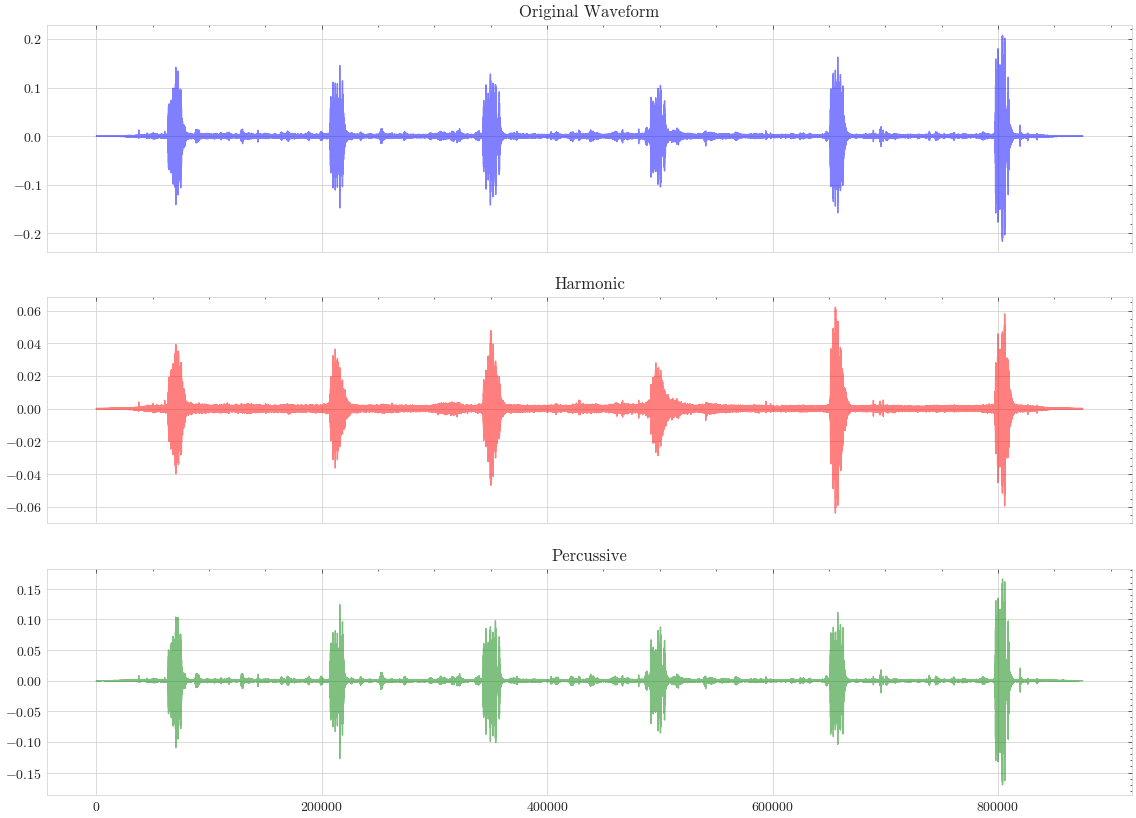

In [28]:
# plot
fig, ax = plt.subplots(nrows=3, sharex=True,figsize=(14,10))
#librosa.display.waveshow(wf, sr=sr, ax=ax[0], label='Original')
ax[0].plot(wf, color='b', alpha=0.5)
ax[0].set(title='Original Waveform')
ax[0].label_outer()

wf_harm, wf_perc = librosa.effects.hpss(wf)
#librosa.display.waveshow(wf_harm, sr=sr, alpha=0.5, ax=ax[1], label='Harmonic')
ax[1].plot(wf_harm, color='r', alpha=0.5)
ax[1].set(title='Harmonic')
#ax[1].legend()
#librosa.display.waveshow(wf_perc, sr=sr, color='r', alpha=0.5, ax=ax[2], label='Percussive')
ax[2].plot(wf_perc, color='g', alpha=0.5)
ax[2].set(title='Percussive');


## Listen to a sample

In [29]:
fname = train_audio_dir + files[file_idx]
print(f'filename: {fname}')
ipd.Audio(fname)

filename: ./train_audio/asbfly/XC134896.ogg


## Spectrogram
* For method 2: Save specrogram waveforms as images, train like an image classifier.
* Check out the first file.

In [30]:
ft = librosa.stft(wf)
ft_db = librosa.amplitude_to_db(np.abs(ft), ref=np.max)
ft_db.shape

(1025, 1710)

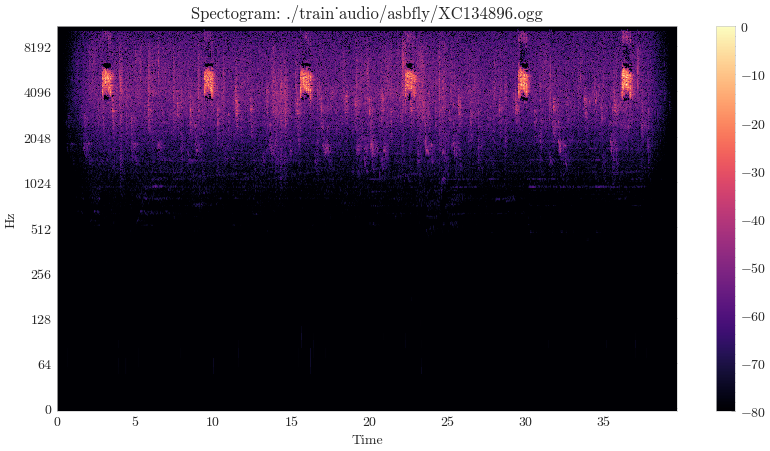

In [31]:
fig,ax = plt.subplots(figsize=(10,5))
img = librosa.display.specshow(ft_db,x_axis='time', y_axis='log',ax=ax)
ax.set_title(f'Spectogram: {fname}')
fig.colorbar(img, ax=ax);

## Mel Spectrogram

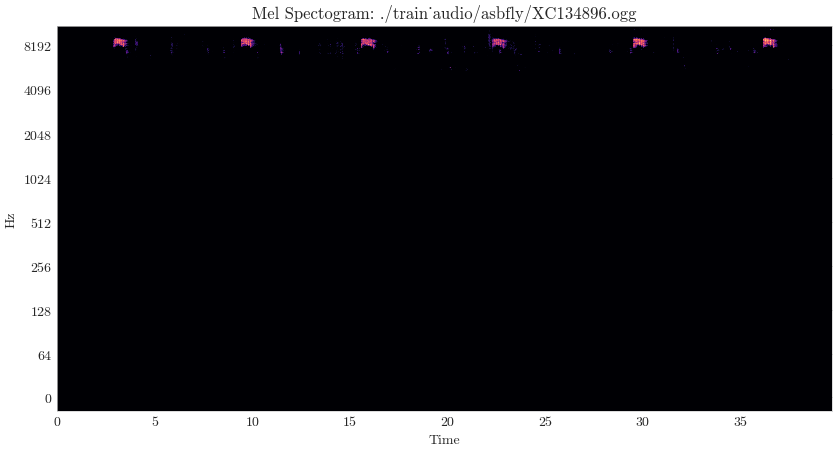

In [32]:
ms = librosa.feature.melspectrogram(y=wf, sr=sr,n_mels=256,)
ms_db = librosa.amplitude_to_db(ms,ref=np.max)

# plot
fig,ax = plt.subplots(figsize=(10,5))
img = librosa.display.specshow(ms_db,x_axis='time', y_axis='log',ax=ax)
ax.set_title(f'Mel Spectogram: {fname}');

### Takeaways
* Mel is dark for this file
* Need to evaluate as to if spectrogram or mel spectrogram will give better results

## Harmonic and Percussive Spectrograms 

Text(0.5, 1.0, 'Percussive Spectogram')

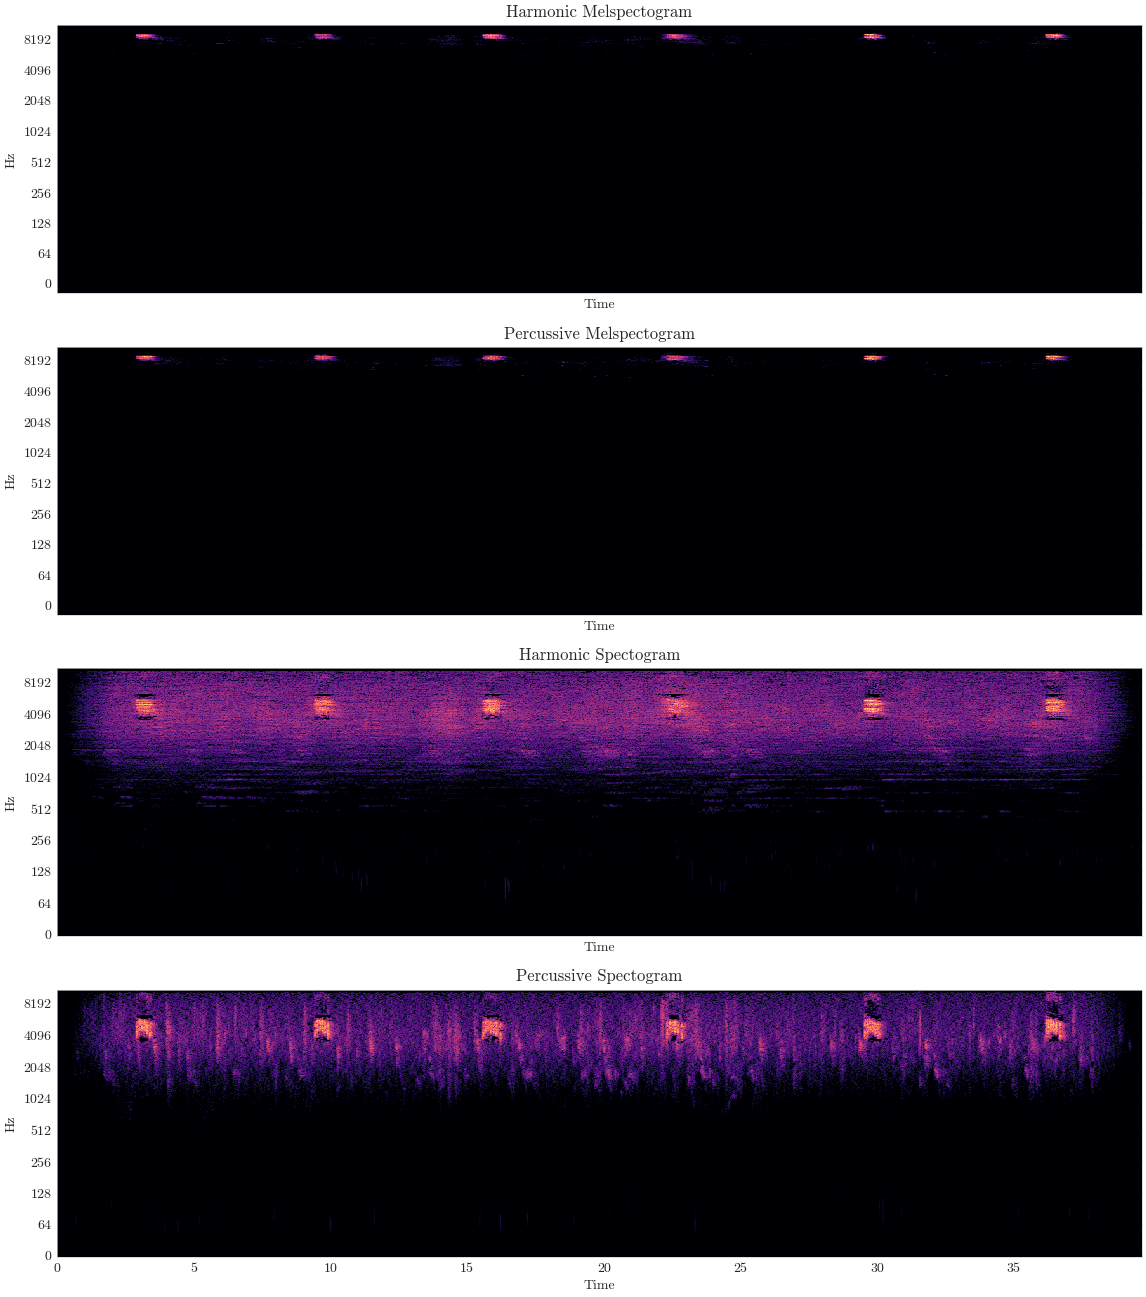

In [33]:
# spectograms - regular first - it is done a slightly different way than the MEL
ft_harm = librosa.stft(wf_harm)
ft_harm_db = librosa.amplitude_to_db(np.abs(ft_harm), ref=np.max)
ft_perc = librosa.stft(wf_perc)
ft_perc_db = librosa.amplitude_to_db(np.abs(ft_perc), ref=np.max)

# MEL spectograms
ms_harm = librosa.feature.melspectrogram(y=wf_harm, sr=sr,n_mels=256,)
ms_harm_db = librosa.amplitude_to_db(ms_harm,ref=np.max)
ms_perc = librosa.feature.melspectrogram(y=wf_perc, sr=sr,n_mels=256,)
ms_perc_db = librosa.amplitude_to_db(ms_perc,ref=np.max)

fig, ax = plt.subplots(nrows=4,sharex=True, figsize=(14,16))
#librosa.display.waveshow(wf, sr=sr, ax=ax[0], label='Original')
#librosa.display.specshow(wf_harm,x_axis='time', y_axis='log',ax=ax)
librosa.display.specshow(ms_harm_db,x_axis='time', y_axis='log',ax=ax[0])
ax[0].set_title('Harmonic Melspectogram')
librosa.display.specshow(ms_harm_db,x_axis='time', y_axis='log',ax=ax[1])
ax[1].set_title('Percussive Melspectogram')
librosa.display.specshow(ft_harm_db,x_axis='time', y_axis='log',ax=ax[2])
ax[2].set_title('Harmonic Spectogram')
librosa.display.specshow(ft_perc_db,x_axis='time', y_axis='log',ax=ax[3])
ax[3].set_title('Percussive Spectogram')


## Zero crossings

In [34]:
FRAME_SIZE = 1024
HOP_LENGTH = 512

# Zero crossings for both harmonic and percussive
wf_zcr = librosa.feature.zero_crossing_rate(wf,frame_length=FRAME_SIZE,hop_length=HOP_LENGTH)[0] * FRAME_SIZE
wf_harm_zcr = librosa.feature.zero_crossing_rate(wf_harm,frame_length=FRAME_SIZE,hop_length=HOP_LENGTH)[0] * FRAME_SIZE

wf_perc_zcr = librosa.feature.zero_crossing_rate(wf_perc,frame_length=FRAME_SIZE,hop_length=HOP_LENGTH)[0] * FRAME_SIZE

[Text(0.5, 1.0, 'Percussive Waveform Zero Crossings')]

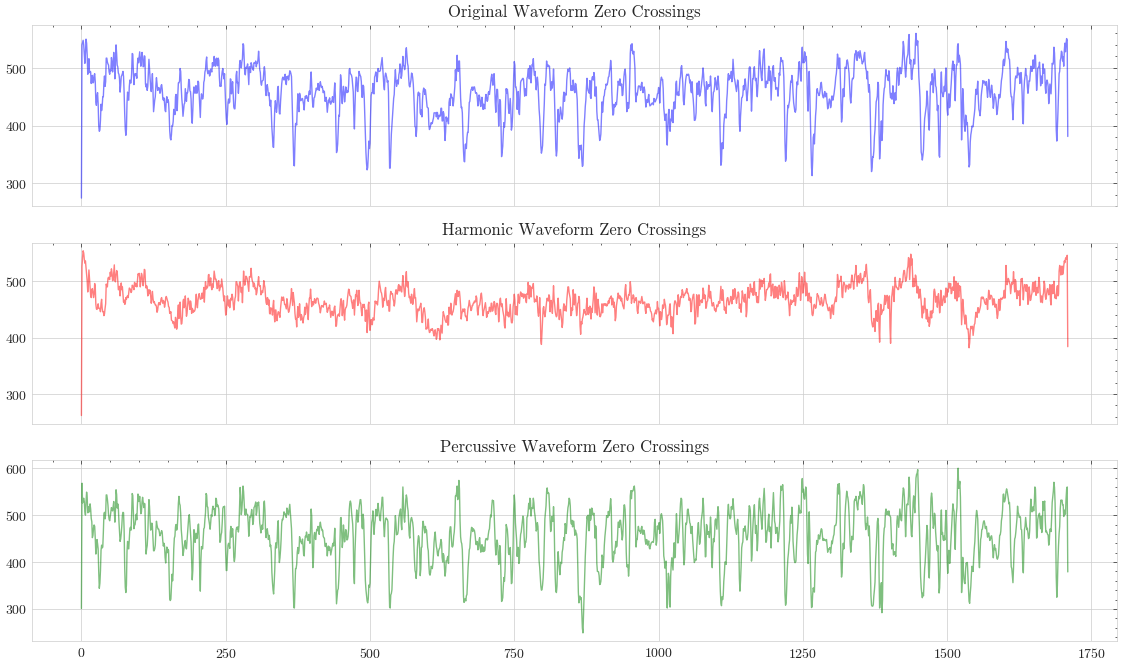

In [36]:
fig,ax = plt.subplots(nrows=3,sharex=True,figsize=(14,8))

#librosa.display.waveshow(wf_zcr, sr=sr, alpha=0.8, ax=ax[0], label='Original Waveform')
ax[0].plot(wf_zcr, color='b', alpha=0.5)
ax[0].set(title='Original Waveform Zero Crossings')
#librosa.display.waveshow(wf_harm_zcr, sr=sr, alpha=0.8, ax=ax[1], label='Harmonic Waveform')
ax[1].plot(wf_harm_zcr, color='r', alpha=0.5)
ax[1].set(title='Harmonic Waveform Zero Crossings')
#librosa.display.waveshow(wf_perc_zcr, sr=sr, alpha=0.8, ax=ax[2], label='Percussive Waveform')
ax[2].plot(wf_perc_zcr, color='g', alpha=0.5)
ax[2].set(title='Percussive Waveform Zero Crossings')

## 1D Fourier Analysis
* TBD

## Models
* TBD, after EDA
* gradient boosted models for frequency based features
* fastai/pytorch/keras for spectrogram classification

## Simple submission
* This is a second check that I have the formatting right
* Basically this mimics the sample submission but parses the filenames and simply predicts the mean
* 

# Submission
* Are we given 5 second chunks or need to chunk each file first?
    * Looks like we need to chunk
        * what about the last segement if < 2.5 second?  Dropped, or predicted on that segment?
        * assume dropped unless find other info
* First, submit sample to verify things are working
*   Each prediction is .005495, which is 1/182
* Next, sumbit means

In [46]:
# First submission just uses the sample submission file to verify things are working
ss.to_csv('submission.csv',index=False)
ss.head()

,row_id,asbfly,ashdro1,ashpri1,ashwoo2,asikoe2,asiope1,aspfly1,aspswi1,barfly1,barswa,bcnher,bkcbul1,bkrfla1,bkskit1,bkwsti,bladro1,blaeag1,blakit1,blhori1,blnmon1,blrwar1,bncwoo3,brakit1,brasta1,...,sqtbul1,stbkin1,sttwoo1,thbwar1,tibfly3,tilwar1,vefnut1,vehpar1,wbbfly1,wemhar1,whbbul2,whbsho3,whbtre1,whbwag1,whbwat1,whbwoo2,whcbar1,whiter2,whrmun,whtkin2,woosan,wynlau1,yebbab1,yebbul3,zitcis1
0,soundscape_1446779_5,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,...,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495
1,soundscape_1446779_10,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,...,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495
2,soundscape_1446779_15,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,...,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495


In [52]:
# Next, sumbit probability based on the value counts in the training data
for col in ss.columns[1:]:
    ss[col] = sum(train.primary_label == col)/len(train)
    
ss.to_csv('submission.csv',index=False)
ss.head()

,row_id,asbfly,ashdro1,ashpri1,ashwoo2,asikoe2,asiope1,aspfly1,aspswi1,barfly1,barswa,bcnher,bkcbul1,bkrfla1,bkskit1,bkwsti,bladro1,blaeag1,blakit1,blhori1,blnmon1,blrwar1,bncwoo3,brakit1,brasta1,...,sqtbul1,stbkin1,sttwoo1,thbwar1,tibfly3,tilwar1,vefnut1,vehpar1,wbbfly1,wemhar1,whbbul2,whbsho3,whbtre1,whbwag1,whbwat1,whbwoo2,whcbar1,whiter2,whrmun,whtkin2,woosan,wynlau1,yebbab1,yebbul3,zitcis1
0,soundscape_1446779_5,0.004293,0.004456,0.003925,0.00184,0.011243,0.000204,0.001063,0.001063,0.000818,0.020442,0.020442,0.000981,0.001186,0.010957,0.020442,0.005111,0.000245,0.009444,0.005765,0.007073,0.020442,0.000286,0.001799,0.000532,...,0.000981,0.004988,0.000818,0.00417,0.004252,0.000859,0.001676,0.001472,0.000286,0.011162,0.002126,0.000899,0.000859,0.00139,0.006828,0.003066,0.00229,0.00924,0.002576,0.007564,0.020442,0.000245,0.001145,0.001227,0.020442
1,soundscape_1446779_10,0.004293,0.004456,0.003925,0.00184,0.011243,0.000204,0.001063,0.001063,0.000818,0.020442,0.020442,0.000981,0.001186,0.010957,0.020442,0.005111,0.000245,0.009444,0.005765,0.007073,0.020442,0.000286,0.001799,0.000532,...,0.000981,0.004988,0.000818,0.00417,0.004252,0.000859,0.001676,0.001472,0.000286,0.011162,0.002126,0.000899,0.000859,0.00139,0.006828,0.003066,0.00229,0.00924,0.002576,0.007564,0.020442,0.000245,0.001145,0.001227,0.020442
2,soundscape_1446779_15,0.004293,0.004456,0.003925,0.00184,0.011243,0.000204,0.001063,0.001063,0.000818,0.020442,0.020442,0.000981,0.001186,0.010957,0.020442,0.005111,0.000245,0.009444,0.005765,0.007073,0.020442,0.000286,0.001799,0.000532,...,0.000981,0.004988,0.000818,0.00417,0.004252,0.000859,0.001676,0.001472,0.000286,0.011162,0.002126,0.000899,0.000859,0.00139,0.006828,0.003066,0.00229,0.00924,0.002576,0.007564,0.020442,0.000245,0.001145,0.001227,0.020442


In [51]:
len(train[train.primary_label == 'asbfly'])/len(train)

0.0042928983196369435

In [53]:
# submit this file using the kaggle api
# !kaggle competitions submit -c birdclef-2024 -f submission.csv -m "Value counts of training data submission"


100%|██████████████████████████████████████| 12.9k/12.9k [00:00<00:00, 15.1kB/s]
400 - Bad Request - Submission not allowed:  This competition only accepts Submissions from Notebooks.
